# Real EEG data example

In [1]:
# author: Tom Stone <tomstone@stanford.edu>
# author: Proloy Das <email:proloyd94@gmail.com>
# License: BSD (3-clause)
%matplotlib widget
%matplotlib widget
import numpy as np

from matplotlib import pyplot
from utils import *


pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "figure.constrained_layout.use": True,
    "savefig.dpi": 300
})
# rng = np.random.default_rng(12345)

Load the saved numpy array `propofol_eeg_demo.npz` with `numpy.load()` ffunction. The data has one array containing single channel EEG data, another array containing the time indices. The EEG data is collected when the participant was undering propofol induced anesthesia.
For this lab, use window 500s - 510s as baseline, window 4705s - 4715s as deep_anesthesia.

Also, the EEG data in Volts, change it to microVolts before carrying out any analysis.

In [32]:
f = np.load('propofol_eeg_demo.npz')
data = f['data'] * 1e6
times = f['times']

In [14]:
baseline = data[0, np.logical_and(times >= 500., times < 510.)]
baseline_time_indices = times[np.logical_and(times >= 500., times < 510.)]
deep_anesthesia = data[0, np.logical_and(times >= 4705., times < 4715.)]
deep_anesthesia_time_indices = times[np.logical_and(times >= 4705., times < 4715.)]


FYI. in real data analysis we are not interested in normalized frequency. Rather we want to know all the power contribution against actual frequecncy. We will need to simply multiply the returned normalized frequency by the sampling frequency to get the frequency bins in terms of the actual frequency (i.e. frequencies in Hz).

Question: how will you compute the sampling frequency from the time index array?

Hint: $$\text{sampling frequency} = \frac{1}{\text{sampling interval}}$$


In [4]:
sfreq = 1 / (times[1] - times[0])

### Baseline
First plot the baseline data, then compute its multitaper sepctrum and plot it. Don't forget to multiply the returned frequency points by sampling frequency.

Text(0.5, 0, 'time (s)')

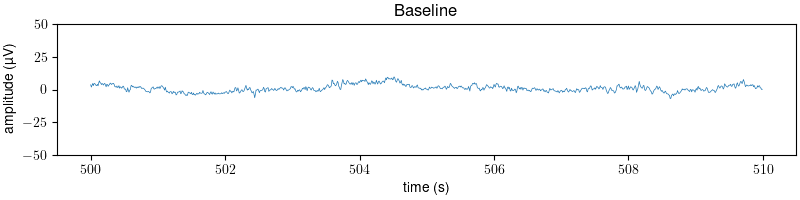

In [5]:
fig, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(baseline_time_indices, baseline, linewidth=0.5)
ax.set_ylim([-50, 50])
ax.set_title('Baseline')
ax.set_ylabel('amplitude (µV)')
ax.set_xlabel('time (s)')

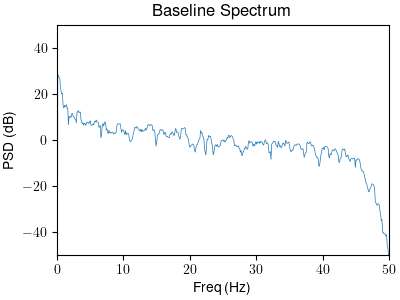

In [19]:
Smtm_xx_est, freqs = compute_multitaper_spectrum(baseline, NW=4, Kmax=5)
freqs *= sfreq
fig, ax = pyplot.subplots(figsize = (4,3))
ax.plot(freqs, 10*np.log10(S_yy_mt_est), linewidth=0.5)
ax.set_xlim([0, sfreq/2])
ax.set_ylim([-50, 50])
ax.set_ylabel('PSD (dB)')
ax.set_xlabel('Freq (Hz)')
_ = ax.set_title('Baseline Spectrum')

Text(0.5, 0, 'Time (s)')

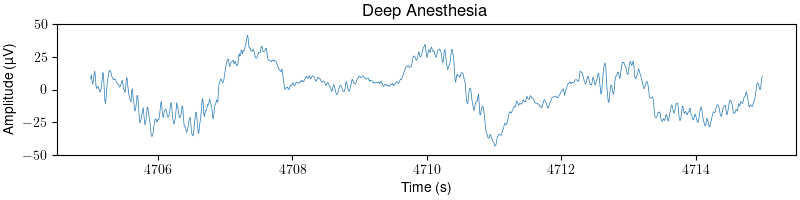

In [8]:
fig, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(deep_anesthesia_time_indices, deep_anesthesia.T, linewidth=0.5)
ax.set_ylim([-50, 50])
ax.set_title('Deep Anesthesia')
ax.set_ylabel('Amplitude (µV)')
ax.set_xlabel('Time (s)')

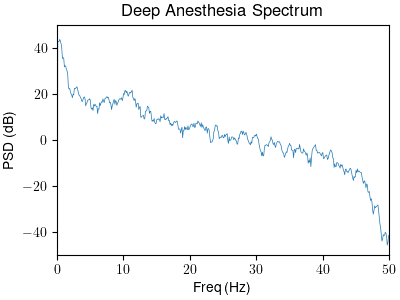

In [18]:
Smtm_xx_est, freqs = compute_multitaper_spectrum(deep_anesthesia, NW=4, Kmax=5)
freqs *= sfreq
fig, ax = pyplot.subplots(figsize = (4,3))
ax.plot(freqs, 10*np.log10(Smtm_xx_est), linewidth=0.5)
ax.set_xlim([0, sfreq/2])
ax.set_ylim([-50, 50])
ax.set_ylabel('PSD (dB)')
ax.set_xlabel('Freq (Hz)')
_ = ax.set_title('Deep Anesthesia Spectrum')

Now we plot the data over the whole experiment to see there is non-stationarity.

Text(0.5, 0, 'Time (s)')

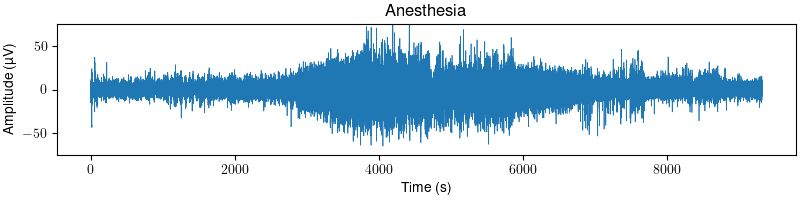

In [24]:
fig, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(times, data.T, linewidth=0.5)
ax.set_ylim([-75, 75])
ax.set_title('Anesthesia')
ax.set_ylabel('Amplitude (µV)')
ax.set_xlabel('Time (s)')

How do we deal with such data with spectrogram?

1. Pick a window of length 5s.
2. Assume stationarity over the interval of 5s and compute the multi-taper spectral density estimate.
3. Move the window 1s forward and repeat.


In [39]:
N = 5 # seconds
window_length = int(N * sfreq)  # number of samples
n = 1 # seconds
sliding_length = int(n * sfreq)  # number of samples

NW = 4
Kmax = 5

# Define a list to keep computed spectrum, and the middle points of the associated time window
Smtm_xx_ests = []
middle_time_ponts = []
# Moving is done by a for loop with python `range` function
for tt in range(0, len(times) - window_length + 1, sliding_length):
    x = data[0, tt:tt+window_length]
    Smtm_xx_est, freqs = compute_multitaper_spectrum(x, NW, Kmax)  # compute multitaper spectrum
    Smtm_xx_ests.append(Smtm_xx_est)
    middle_time_ponts.append(times[tt:tt+window_length].mean())  # middle point of the time window
freqs *= sfreq
Smtm_xx_ests = np.vstack(Smtm_xx_ests)
middle_time_ponts = np.array(middle_time_ponts)


Now we plot the computed spectrogram as a 2D plot.

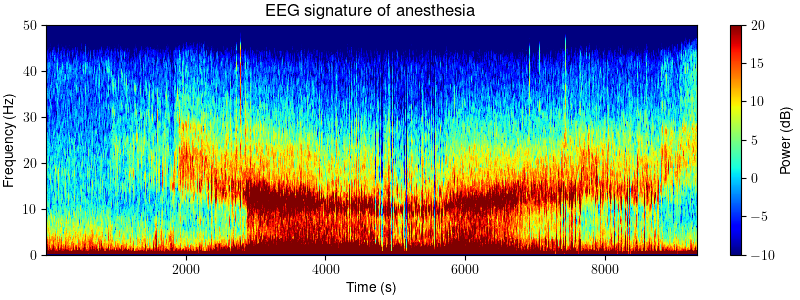

In [52]:
fix, ax = pyplot.subplots(figsize=(8, 3))
im = ax.pcolormesh(middle_time_ponts, freqs, 10*np.log10(Smtm_xx_ests.T), cmap='jet', clim=[-10, 20], shading='nearest')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Power (dB)')
ax.set_ylim([0, sfreq/2])
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
_ = ax.set_title('EEG signature of anesthesia')

Hopefully, we are able to empower you in using these tools! Happy experimenting with them!